This script is on Colab and should be run on GPU

https://colab.research.google.com/drive/11cUYv_mWVjOJhQtuOOFnk_O5i2fiPtzf#scrollTo=-x3P74R80Dcd&uniqifier=1

In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla T4'

In [4]:
# prompt: upload file and read csv

from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

clinical = pd.read_csv(io.BytesIO(uploaded['clinical_data.csv']))


Saving clinical_data.csv to clinical_data.csv


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

clinical = clinical[clinical['Image_name'].str.contains('CM') & clinical['Image_name'].str.contains('MLO')]

clinical["Notes"] = "[CLS] " + clinical["Findings"] + " [SEP]"


# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the labels
clinical["Labels"] = label_encoder.fit_transform(clinical["Pathology Classification/ Follow up"])

label_mapping = {original: encoded for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

print("Label Mapping:")
for original, encoded in label_mapping.items():
    print(f"{original}: {encoded}")


# Split into train and validation DataFrames
val_list = ['P251_R_CM_MLO', 'P55_R_CM_MLO', 'P261_L_CM_MLO', 'P96_R_CM_MLO', 'P111_R_CM_MLO', 'P281_R_CM_MLO', 'P278_L_CM_MLO', 'P280_L_CM_MLO', 'P110_L_CM_MLO', 'P59_R_CM_MLO', 'P155_L_CM_MLO', 'P318_R_CM_MLO', 'P131_L_CM_MLO', 'P123_R_CM_MLO', 'P1_L_CM_MLO', 'P322_L_CM_MLO', 'P271_L_CM_MLO', 'P56_L_CM_MLO', 'P246_R_CM_MLO', 'P16_R_CM_MLO', 'P214_L_CM_MLO', 'P213_L_CM_MLO', 'P230_R_CM_MLO', 'P288_L_CM_MLO', 'P312_L_CM_MLO', 'P193_L_CM_MLO', 'P139_R_CM_MLO', 'P46_L_CM_MLO', 'P179_L_CM_MLO', 'P148_R_CM_MLO', 'P62_L_CM_MLO', 'P210_L_CM_MLO', 'P40_R_CM_MLO', 'P138_L_CM_MLO', 'P311_L_CM_MLO', 'P71_L_CM_MLO', 'P104_L_CM_MLO', 'P295_L_CM_MLO', 'P295_R_CM_MLO', 'P161_L_CM_MLO', 'P2_L_CM_MLO', 'P80_L_CM_MLO', 'P228_L_CM_MLO', 'P319_R_CM_MLO', 'P319_L_CM_MLO', 'P128_L_CM_MLO', 'P182_R_CM_MLO', 'P271_R_CM_MLO', 'P61_L_CM_MLO', 'P21_R_CM_MLO', 'P236_L_CM_MLO', 'P196_L_CM_MLO', 'P11_R_CM_MLO', 'P324_R_CM_MLO', 'P191_R_CM_MLO', 'P67_R_CM_MLO', 'P270_R_CM_MLO', 'P307_R_CM_MLO', 'P181_R_CM_MLO', 'P8_L_CM_MLO', 'P54_L_CM_MLO', 'P14_L_CM_MLO', 'P65_R_CM_MLO', 'P77_L_CM_MLO', 'P310_R_CM_MLO', 'P302_R_CM_MLO', 'P52_R_CM_MLO', 'P52_L_CM_MLO', 'P226_R_CM_MLO', 'P273_R_CM_MLO', 'P226_L_CM_MLO', 'P24_L_CM_MLO', 'P29_R_CM_MLO', 'P175_R_CM_MLO', 'P58_L_CM_MLO', 'P127_L_CM_MLO', 'P59_L_CM_MLO', 'P268_R_CM_MLO', 'P282_L_CM_MLO', 'P92_R_CM_MLO', 'P123_L_CM_MLO', 'P219_L_CM_MLO', 'P7_R_CM_MLO', 'P146_L_CM_MLO', 'P291_L_CM_MLO', 'P322_R_CM_MLO', 'P207_R_CM_MLO', 'P190_R_CM_MLO', 'P197_L_CM_MLO', 'P215_R_CM_MLO', 'P325_L_CM_MLO', 'P33_L_CM_MLO', 'P276_R_CM_MLO', 'P51_L_CM_MLO', 'P324_L_CM_MLO', 'P206_R_CM_MLO', 'P56_R_CM_MLO', 'P237_R_CM_MLO', 'P312_R_CM_MLO', 'P158_L_CM_MLO', 'P230_L_CM_MLO']
df_val = clinical[clinical['Image_name'].isin(val_list)]
df_train = clinical[~clinical['Image_name'].isin(val_list)]

train_clinical_notes = df_train.Notes.values
val_clinical_notes = df_val.Notes.values

train_labels = list(df_train["Labels"])
val_labels = list(df_val["Labels"])



Label Mapping:
Benign: 0
Malignant: 1
Normal: 2


In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# # clinical = pd.read_csv('/content/clinical_data.csv')
# clinical = clinical[clinical['Image_name'].str.contains('CM') & clinical['Image_name'].str.contains('MLO')]

# clinical["Notes"] = "[CLS] " + clinical["Findings"] + " [SEP]"
# clinical_notes = clinical.Notes.values

# labels = list(clinical["Pathology Classification/ Follow up"])


# # Create a LabelEncoder object
# label_encoder = LabelEncoder()

# # Fit and transform the labels
# labels = label_encoder.fit_transform(labels)

# # Create a dictionary to show the mapping
# label_mapping = {original: encoded for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

# print("Label Mapping:")
# for original, encoded in label_mapping.items():
#     print(f"{original}: {encoded}")

# print("\nOriginal Labels:", labels)


Label Mapping:
Benign: 0
Malignant: 1
Normal: 2

Original Labels: [1 0 0 1 0 2 2 2 0 2 1 2 2 0 0 0 2 1 2 0 0 2 1 2 0 0 1 2 0 0 0 2 1 2 0 1 1
 0 1 2 2 2 0 0 1 2 2 1 0 0 2 2 1 1 2 0 0 2 2 0 0 0 2 0 2 2 2 1 2 2 2 0 2 1
 2 2 1 2 1 2 1 2 0 0 0 0 2 0 1 1 0 0 2 0 0 2 2 1 2 0 2 2 2 2 0 2 0 2 1 2 1
 2 1 1 0 2 1 0 2 1 2 1 2 0 2 2 2 1 1 2 2 1 2 2 1 2 0 1 2 2 2 0 2 2 1 2 0 2
 0 1 2 1 1 2 1 1 2 2 1 0 2 1 2 1 2 2 2 1 2 2 0 1 1 2 1 2 2 0 2 1 2 2 0 2 1
 1 0 2 1 2 2 0 1 1 0 0 0 0 2 2 0 0 2 0 2 2 1 1 2 2 0 2 1 0 2 1 1 0 0 2 1 2
 1 0 2 2 0 0 1 2 0 1 0 1 2 0 0 0 0 1 2 1 0 1 2 1 2 1 0 2 0 1 0 2 0 0 2 1 1
 0 2 2 1 1 2 0 2 1 0 1 2 2 0 1 2 2 1 1 0 0 2 1 2 2 2 2 1 2 1 2 1 2 1 1 0 1
 0 2 1 2 1 2 1 2 1 2 1 2 0 1 2 1 2 2 1 2 0 2 2 0 2 0 0 0 1 2 0 2 1 2 1 0 0
 2 0 2 0 0 0 1 2 2 1 1 2 2 2 1 1 2 0 1 2 1 2 1 2 1 2 1 2 0 1 1 1 2 1 2 2 1
 1 2 2 1 2 1 1 0 2 1 1 1 1 2 2 1 2 1 2 1 0 2 0 1 2 1 2 1 0 1 2 1 2 1 2 1 0
 1 1 2 2 1 1 2 2 2 2 2 1 0 0 1 0 1 2 0 1 2 1 1 2 1 2 1 2 1 2 0 2 0 0 0 2 1
 2 1 2 1 1 2 0 2 2 0 2 0 2 1 1 2 1

<ipython-input-5-8583464e03cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical["Notes"] = "[CLS] " + clinical["Findings"] + " [SEP]"


In [ ]:
# # from pytorch_pretrained_bert import BertTokenizer, BertConfig
# from transformers import BertTokenizer
# from transformers import AutoTokenizer, AutoModel

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# tokenized_clinical_notes = [tokenizer.tokenize(note) for note in clinical_notes]
# print ("Tokenize the first sentence:")
# print (tokenized_clinical_notes[0])

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Tokenize the first sentence:
['[CLS]', 'he', '##tero', '##gen', '##ous', 'non', 'mass', 'enhance', '##ment', '[SEP]']


In [15]:
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModel

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

train_tokenized_clinical_notes = [tokenizer.tokenize(note) for note in train_clinical_notes]
val_tokenized_trained_clinical_notes = [tokenizer.tokenize(note) for note in val_clinical_notes]
print ("Tokenize the first sentence:")
print (train_tokenized_clinical_notes[0])

Tokenize the first sentence:
['[CLS]', 'multiple', 'ho', '##mo', '##gen', '##ously', 'enhancing', 'masses', '[SEP]']


In [17]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 128

train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_clinical_notes]
val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in val_tokenized_trained_clinical_notes]

train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# # Create attention masks
# attention_masks = []

# # Create a mask of 1s for each token followed by 0s for padding
# for seq in input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   attention_masks.append(seq_mask)

In [18]:
# Create attention masks
train_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in train_input_ids:
  seq_mask = [float(i>0) for i in seq]
  train_attention_masks.append(seq_mask)

# Create attention masks
val_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in val_input_ids:
  seq_mask = [float(i>0) for i in seq]
  val_attention_masks.append(seq_mask)

In [ ]:
# from sklearn.model_selection import train_test_split

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
#                                                             random_state=42, test_size=0.2)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=42, test_size=0.2)

In [19]:
train_inputs, validation_inputs, train_labels, validation_labels = train_input_ids, val_input_ids, train_labels, val_labels
train_masks, validation_masks = train_attention_masks, val_attention_masks

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
# from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()
# model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
# Load model directly
from transformers import AutoModelForSequenceClassification

# Load Bio_ClinicalBERT with a classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=3  # Specify the number of labels for classification
)
model.cuda()


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
from tqdm import tqdm, trange
from pytorch_pretrained_bert import BertAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)


# Function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    # loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # train_loss_set.append(loss.item())


    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    # Extract loss correctly
    loss = outputs.loss  # Get the loss tensor
    train_loss_set = []
    train_loss_set.append(loss.item())  # Convert to scalar and store
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  all_labels = []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    # logits = logits.detach().cpu().numpy()
    logits = outputs.logits  # Access logits from the output object
    logits = logits.detach().cpu().numpy()  # Detach and move to CPU
    label_ids = b_labels.to('cpu').numpy()


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)


    pred_labels = np.argmax(logits, axis=1).flatten()
    all_labels.append(pred_labels)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.7144796763147626


Epoch:  25%|██▌       | 1/4 [00:08<00:26,  8.94s/it]

Validation Accuracy: 0.6815878378378378
Train loss: 0.40082251174109323


Epoch:  50%|█████     | 2/4 [00:16<00:16,  8.36s/it]

Validation Accuracy: 0.8429054054054055
Train loss: 0.298589180622782


Epoch:  75%|███████▌  | 3/4 [00:24<00:08,  8.08s/it]

Validation Accuracy: 0.7768158783783784
Train loss: 0.2567578139049666


Epoch: 100%|██████████| 4/4 [00:32<00:00,  8.12s/it]

Validation Accuracy: 0.8699324324324325


# BERT

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

unlisted = []
for sublist in all_labels:
    for item in sublist:
        unlisted.append(item)

def evaluate(pred,label):
  acc = accuracy_score(pred,label)
  print(f"Validation Accuracy: {acc:.4f}")

    # Calculate F1 score for each class
  f1_scores = f1_score(label, pred, average=None)
  for i, score in enumerate(f1_scores):
      print(f"F1 Score for class {i}: {score:.4f}")

  return

evaluate(unlisted,validation_labels)



Validation Accuracy: 0.8812
F1 Score for class 0: 0.8333
F1 Score for class 1: 0.8077
F1 Score for class 2: 0.9556


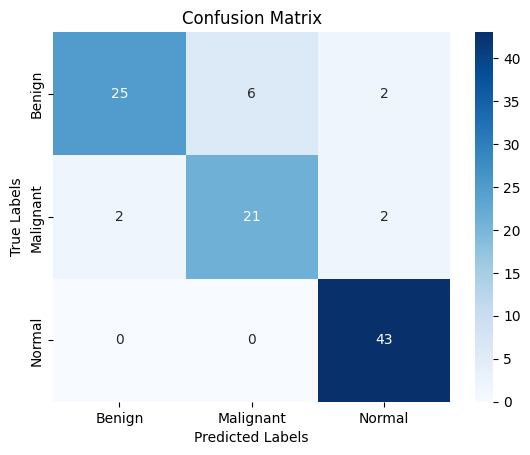

In [ ]:
# label_ids
validation_labels
label_ids
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(validation_labels, unlisted)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant", "Normal"], yticklabels=["Benign", "Malignant", "Normal"])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model and tokenizer
save_directory = "saved_model"
model.save_pretrained(save_directory)

# ClinicalBert

In [23]:
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

unlisted = []
for sublist in all_labels:
    for item in sublist:
        unlisted.append(item)

def evaluate(pred,label):
  acc = accuracy_score(pred,label)
  print(f"Validation Accuracy: {acc:.4f}")

    # Calculate F1 score for each class
  f1_scores = f1_score(label, pred, average=None)
  for i, score in enumerate(f1_scores):
      print(f"F1 Score for class {i}: {score:.4f}")

  return

evaluate(unlisted,validation_labels)


Validation Accuracy: 0.8713
F1 Score for class 0: 0.8136
F1 Score for class 1: 0.7925
F1 Score for class 2: 0.9556


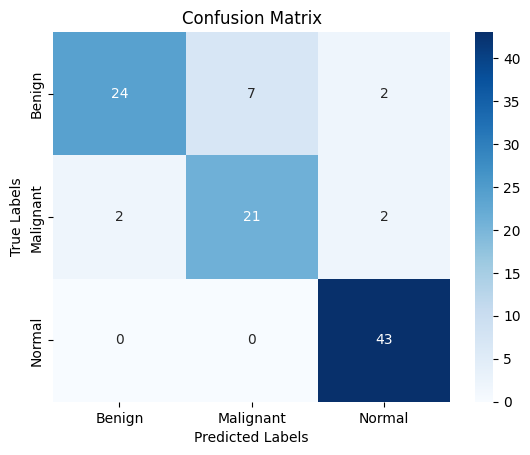

In [24]:
# label_ids
validation_labels
label_ids
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(validation_labels, unlisted)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant", "Normal"], yticklabels=["Benign", "Malignant", "Normal"])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Save the model and tokenizer
save_directory = "saved_model"
model.save_pretrained(save_directory)

# Load Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name_or_path = "kashif/stack-llama-2" #path/to/your/model/or/name/on/hub
device = "cpu" # or "cuda" if you have a GPU

model = AutoModelForCausalLM.from_pretrained(model_name_or_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

inputs = tokenizer.encode("This movie was really", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))

In [ ]:
newmodel = AutoModelForSequenceClassification.from_pretrained(
    "/content/saved_model",
    num_labels=3  # Specify the number of labels for classification
)

newmodel.cuda()

newmodel.eval()


for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = newmodel(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    # logits = logits.detach().cpu().numpy()
    logits = outputs.logits  # Access logits from the output object
    logits = logits.detach().cpu().numpy()  # Detach and move to CPU
    label_ids = b_labels.to('cpu').numpy()


    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

